In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from matplotlib import pyplot as plt
from collections import Counter

2024-01-24 14:34:14.249960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 14:34:14.249998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 14:34:14.277760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 14:34:14.337360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 14:34:15.088182: W tensorflow/compiler/tf2

In [3]:
# Get data and see how many images we have
data_dir = pathlib.Path('../lol_skins/skins')

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

7985

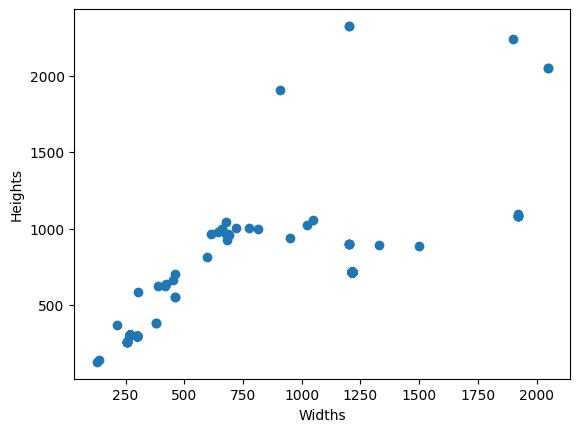

In [4]:
# plot widths vs heights
widths = []
heights = []

all = list(data_dir.glob("*/*.jpg"))
for i in range(len(all)):
    skin = PIL.Image.open(all[i])
    widths.append(skin.width)
    heights.append(skin.height)

plt.scatter(list(widths), list(heights))
plt.xlabel("Widths")
plt.ylabel("Heights")
plt.show()

In [5]:
batch_size = 32
img_height = 244
img_width = 244

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Further split training into validation set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 7985 files belonging to 166 classes.
Using 6388 files for training.


2024-01-24 14:34:23.180967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 14:34:23.269482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 14:34:23.269519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 14:34:23.271083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 14:34:23.271115: I external/local_xla/xla/stream_executor

Found 7985 files belonging to 166 classes.
Using 1597 files for validation.


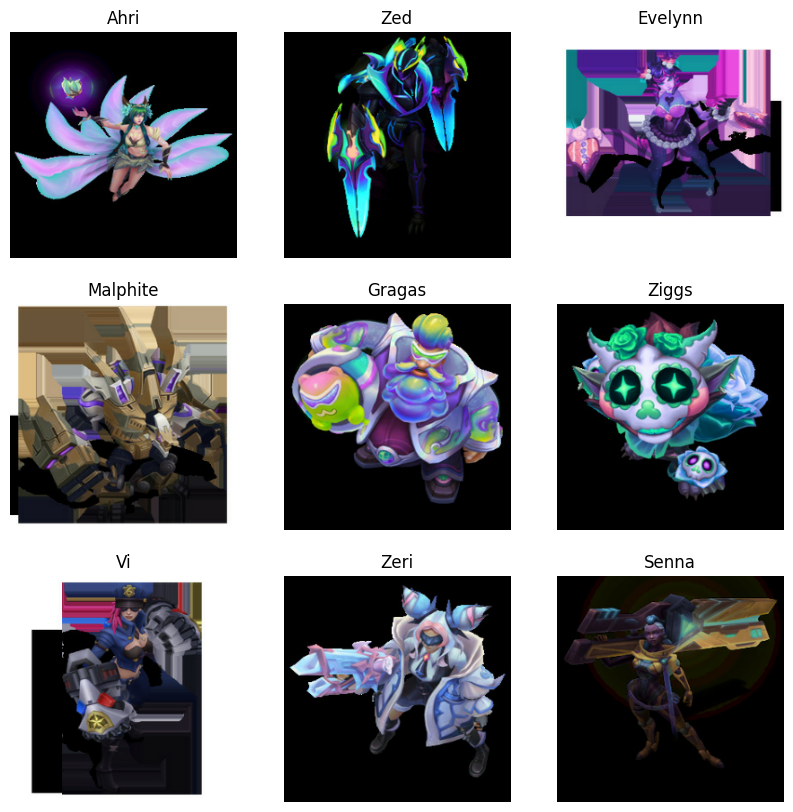

In [7]:
# All class names of the training dataset
class_names = train_ds.class_names
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [8]:
# Standardize data
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Prefetch data for improved performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Baseline Model

In [12]:
# Train a CNN as a baseline
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
base_model_history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2024-01-24 14:37:02.002317: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-24 14:37:02.879775: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5648328c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 14:37:02.879799: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-24 14:37:02.888517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706135822.951355    3377 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 12s 42ms/step - loss: 2.8197 - accuracy: 0.4759 - val_loss: 1.2408 - val_accuracy: 0.7634
Epoch 2/10
200/200 [==============================] - 5s 27ms/step - loss: 0.9819 - accuracy: 0.7949 - val_loss: 1.5115 - val_accuracy: 0.7542
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.5377 - accuracy: 0.8923 - val_loss: 2.0200 - val_accuracy: 0.7560
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 0.3362 - accuracy: 0.9357 - val_loss: 1.9022 - val_accuracy: 0.7800
Epoch 5/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2158 - accuracy: 0.9643 - val_loss: 2.5426 - val_accuracy: 0.7800
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.1672 - accuracy: 0.9751 - val_loss: 1.8567 - val_accuracy: 0.7856
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1209 - accuracy: 0.9822 - val_loss: 1.8536 - val_accuracy: 0.7856
Epoch 8/1

Text(0.5, 1.0, 'Training and Validation loss')

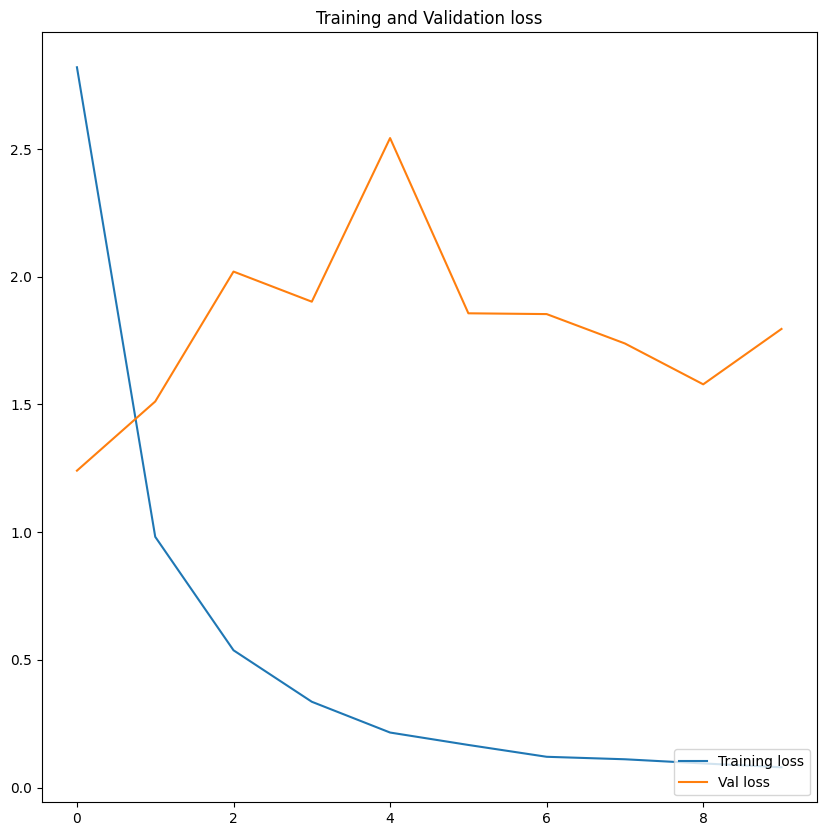

In [15]:
# Plot train loss vs validation loss
loss = base_model_history.history['loss']
val_loss = base_model_history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.plot(range(10), loss, label='Training loss')
plt.plot(range(10), val_loss, label='Val loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

The model shows clear sign of overfitting.

What we can try:
- Smaller model
- More training data
- Add regularization

## Data Augmentation

### An attempt at getting more training data

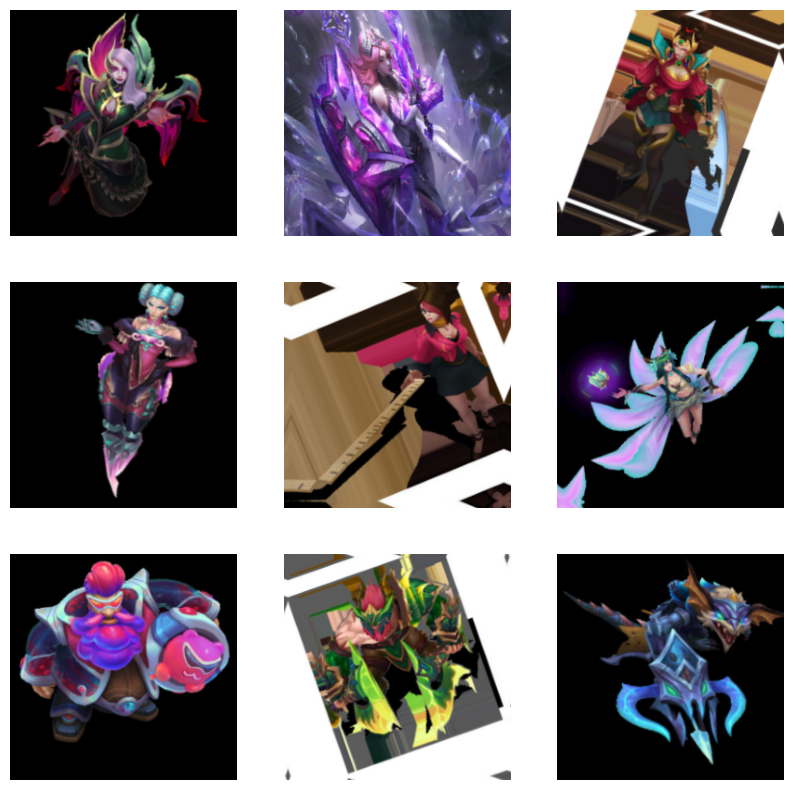

In [16]:
data_augmentation = tf.keras.Sequential(
    [
         tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
         tf.keras.layers.RandomRotation(0.1),
         tf.keras.layers.RandomZoom(0.1),
    ]
)

plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented[i].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
# Try the baseline model again with data augmentation
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, name="outputs")
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 122, 122, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 61, 61, 32)        0         
 ng2D)                                                

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Train for 30 epochs
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/15


2024-01-24 14:38:58.528997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 12s 43ms/step - loss: 4.9832 - accuracy: 0.0254 - val_loss: 4.6779 - val_accuracy: 0.0499
Epoch 2/15
200/200 [==============================] - 7s 33ms/step - loss: 4.1427 - accuracy: 0.1384 - val_loss: 3.5670 - val_accuracy: 0.2366
Epoch 3/15
200/200 [==============================] - 7s 34ms/step - loss: 3.3384 - accuracy: 0.2782 - val_loss: 2.9559 - val_accuracy: 0.3420
Epoch 4/15
200/200 [==============================] - 7s 33ms/step - loss: 2.8486 - accuracy: 0.3779 - val_loss: 2.4065 - val_accuracy: 0.4621
Epoch 5/15
200/200 [==============================] - 7s 34ms/step - loss: 2.5179 - accuracy: 0.4490 - val_loss: 2.2083 - val_accuracy: 0.5157
Epoch 6/15
200/200 [==============================] - 7s 34ms/step - loss: 2.2815 - accuracy: 0.5038 - val_loss: 1.9013 - val_accuracy: 0.5823
Epoch 7/15
200/200 [==============================] - 7s 33ms/step - loss: 2.0903 - accuracy: 0.5488 - val_loss: 1.7826 - val_accuracy: 0.6137
Epoch 8/1

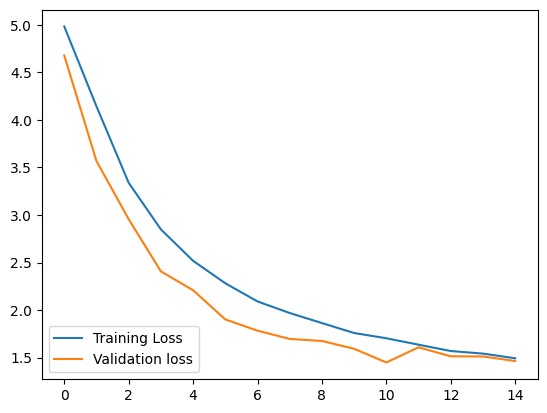

In [19]:
# Plot training vs val loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation loss')
plt.legend(loc='lower left')
plt.show()

It looks here like we can continue training becausae both training loss and validation loss continues to lower.

We can observe that validation loss is lower than training loss. This is due to dropping out.

In [20]:
# Train for 10 more epochs
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 7s 33ms/step - loss: 1.4738 - accuracy: 0.6846 - val_loss: 1.3983 - val_accuracy: 0.7394
Epoch 2/10
200/200 [==============================] - 7s 33ms/step - loss: 1.4271 - accuracy: 0.6921 - val_loss: 1.4835 - val_accuracy: 0.7264
Epoch 3/10
200/200 [==============================] - 7s 33ms/step - loss: 1.3899 - accuracy: 0.7002 - val_loss: 1.3740 - val_accuracy: 0.7338
Epoch 4/10
200/200 [==============================] - 7s 33ms/step - loss: 1.4082 - accuracy: 0.6972 - val_loss: 1.3845 - val_accuracy: 0.7486
Epoch 5/10
200/200 [==============================] - 7s 33ms/step - loss: 1.3803 - accuracy: 0.7052 - val_loss: 1.3638 - val_accuracy: 0.7542
Epoch 6/10
200/200 [==============================] - 7s 33ms/step - loss: 1.3449 - accuracy: 0.7116 - val_loss: 1.3684 - val_accuracy: 0.7449
Epoch 7/10
200/200 [==============================] - 7s 33ms/step - loss: 1.3296 - accuracy: 0.7148 - val_loss: 1.3754 - val_accuracy: 0.7449

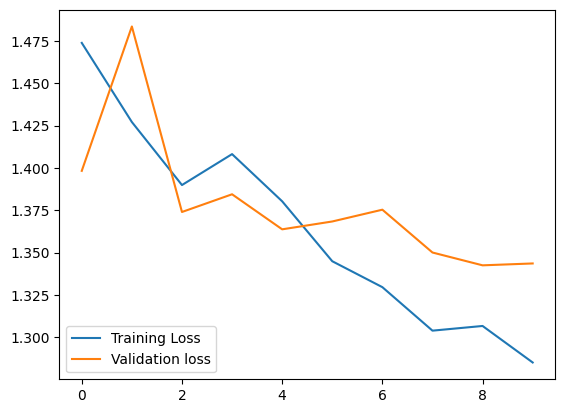

In [22]:
# Plot training vs val loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation loss')
plt.legend(loc='lower left')
plt.show()

While both training loss and validation both goes down as a general trend, we can now spot some early sign of overfitting. The sign isn't clear, so we should train for 15 more epochs to see if the model improves or stays the same.

This time, we add early stopping to prevent our model from overfitting

In [25]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/15
200/200 [==============================] - 7s 33ms/step - loss: 1.1125 - accuracy: 0.7583 - val_loss: 1.3983 - val_accuracy: 0.7634
Epoch 2/15
200/200 [==============================] - 7s 33ms/step - loss: 1.1056 - accuracy: 0.7574 - val_loss: 1.4136 - val_accuracy: 0.7671
Epoch 3/15
200/200 [==============================] - 7s 33ms/step - loss: 1.0767 - accuracy: 0.7599 - val_loss: 1.4311 - val_accuracy: 0.7597
Epoch 4/15
200/200 [==============================] - 7s 33ms/step - loss: 1.0843 - accuracy: 0.7559 - val_loss: 1.4820 - val_accuracy: 0.7560


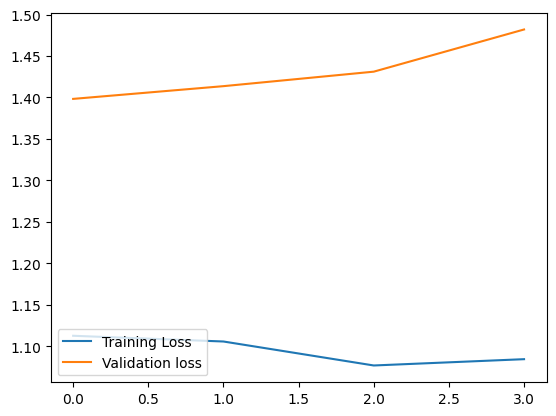

In [27]:
# Plot training vs val loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(4), loss, label='Training Loss')
plt.plot(range(4), val_loss, label='Validation loss')
plt.legend(loc='lower left')
plt.show()

At this point the model is clearly overfitting. We should stop training this baseline model.

Insight so far:
- Without regularization, the model seems to overfit at 25 epochs.
- Baseline model was able to achieve ~75% accuracy on validation set.

Next steps:
- Add regularization to the baseline model and train again.
- Add more training data.
- Use simpler model (although this is one of the simplest).
- Use higher resolution image so that the model can capture better insights? This is not guaranteed, but worth trying.
  

# Regularized baseline model

In [36]:
regularized_model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, name="outputs")
])

regularized_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 122, 122, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 61, 61, 32)        0         
 ng2D)                                                

In [37]:
# compile model
regularized_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

epochs = 30
# create a early stopping callback to pick model at its best
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = regularized_model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                               callbacks=[callback])

Epoch 1/30
200/200 [==============================] - 8s 36ms/step - loss: 5.2982 - accuracy: 0.0100 - val_loss: 5.0973 - val_accuracy: 0.0074
Epoch 2/30
200/200 [==============================] - 8s 39ms/step - loss: 5.0877 - accuracy: 0.0125 - val_loss: 5.0970 - val_accuracy: 0.0129
Epoch 3/30
200/200 [==============================] - 7s 35ms/step - loss: 5.0716 - accuracy: 0.0172 - val_loss: 5.0398 - val_accuracy: 0.0203
Epoch 4/30
200/200 [==============================] - 7s 35ms/step - loss: 4.9643 - accuracy: 0.0313 - val_loss: 4.9763 - val_accuracy: 0.0296
Epoch 5/30
200/200 [==============================] - 7s 36ms/step - loss: 4.7696 - accuracy: 0.0532 - val_loss: 4.6714 - val_accuracy: 0.0758
Epoch 6/30
200/200 [==============================] - 7s 36ms/step - loss: 4.4947 - accuracy: 0.0963 - val_loss: 4.3485 - val_accuracy: 0.1183
Epoch 7/30
200/200 [==============================] - 7s 37ms/step - loss: 4.2125 - accuracy: 0.1511 - val_loss: 4.1312 - val_accuracy: 0.1608

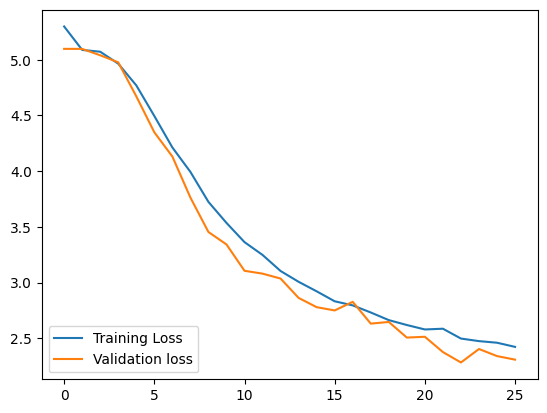

In [39]:
# Plot training vs val loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(26), loss, label='Training Loss')
plt.plot(range(26), val_loss, label='Validation loss')
plt.legend(loc='lower left')
plt.show()

It begins showing sign of overfitting, although very slightly. What is worth a shot here, since we are 25+ epochs into training, is to reduce the learning rate of our optimizer a little and continue training for 20 more epochs even if the validation loss doesn't decrease.

This will overfit our model, but because the current state of the model isn't even good, it's worth trying.

In [40]:
regularized_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 * 0.1),
    metrics=['accuracy']
)

history = regularized_model.fit(train_ds, validation_data=val_ds, initial_epoch=epochs, epochs=epochs + 20)

Epoch 31/50


2024-01-24 15:15:20.719279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 8s 35ms/step - loss: 2.2207 - accuracy: 0.6049 - val_loss: 2.1299 - val_accuracy: 0.6580
Epoch 32/50
200/200 [==============================] - 7s 35ms/step - loss: 2.0978 - accuracy: 0.6321 - val_loss: 2.0383 - val_accuracy: 0.6784
Epoch 33/50
200/200 [==============================] - 7s 35ms/step - loss: 2.0310 - accuracy: 0.6404 - val_loss: 2.0153 - val_accuracy: 0.6821
Epoch 34/50
200/200 [==============================] - 7s 36ms/step - loss: 2.0028 - accuracy: 0.6456 - val_loss: 2.0040 - val_accuracy: 0.6765
Epoch 35/50
200/200 [==============================] - 7s 35ms/step - loss: 1.9430 - accuracy: 0.6544 - val_loss: 1.9819 - val_accuracy: 0.6728
Epoch 36/50
200/200 [==============================] - 7s 35ms/step - loss: 1.9190 - accuracy: 0.6548 - val_loss: 1.9464 - val_accuracy: 0.6821
Epoch 37/50
200/200 [==============================] - 7s 35ms/step - loss: 1.9017 - accuracy: 0.6558 - val_loss: 1.9106 - val_accuracy: 0.6876
Epoc

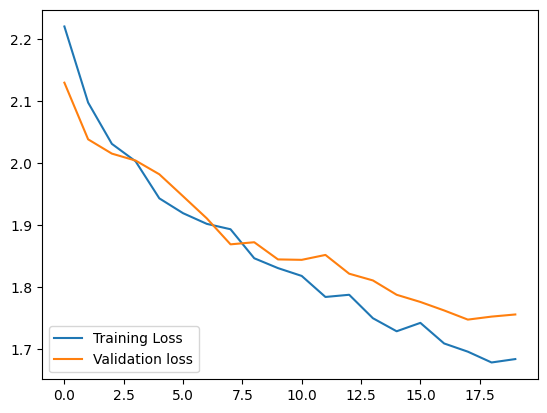

In [42]:
# Plot training vs val loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation loss')
plt.legend(loc='lower left')
plt.show()

We should train for another 20. Somehow val_loss is still dropping.

In [43]:
regularized_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 * 0.1),
    metrics=['accuracy']
)
epochs = 50
history = regularized_model.fit(train_ds, validation_data=val_ds, initial_epoch=epochs, epochs=epochs + 20)

Epoch 51/70


2024-01-24 15:20:26.270093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 8s 36ms/step - loss: 1.6573 - accuracy: 0.6943 - val_loss: 1.7332 - val_accuracy: 0.7135
Epoch 52/70
200/200 [==============================] - 8s 40ms/step - loss: 1.6510 - accuracy: 0.6924 - val_loss: 1.7350 - val_accuracy: 0.7135
Epoch 53/70
200/200 [==============================] - 7s 35ms/step - loss: 1.6412 - accuracy: 0.6913 - val_loss: 1.7296 - val_accuracy: 0.7006
Epoch 54/70
200/200 [==============================] - 7s 37ms/step - loss: 1.6335 - accuracy: 0.6960 - val_loss: 1.7358 - val_accuracy: 0.7098
Epoch 55/70
200/200 [==============================] - 8s 39ms/step - loss: 1.6321 - accuracy: 0.6944 - val_loss: 1.7103 - val_accuracy: 0.7098
Epoch 56/70
200/200 [==============================] - 8s 38ms/step - loss: 1.6154 - accuracy: 0.6927 - val_loss: 1.6896 - val_accuracy: 0.7190
Epoch 57/70
200/200 [==============================] - 7s 35ms/step - loss: 1.6134 - accuracy: 0.6925 - val_loss: 1.7181 - val_accuracy: 0.7190
Epoc

Validation loss still drops, but at this point there are chances that we're overfitting the validation set.

Overall:
- The regularized model achieves worse performance than the non-regularized model, which makes sense.

What's left to solve this problem is to collect more training data.

However, what we can still do is to not use a random neural network architecture like we have used here.
Instead, we could use transfer learning and fine-tuning to see if we can perhaps achieve a better result.

# Use Modern architecture Convolutional Neural Network

# ResNet50

In [45]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [47]:
# Load the base model
base_model = ResNet50(weights='imagenet', input_shape=(244, 244, 3), include_top=False)

# Freeze the base models
base_model.trainable = False

inputs = tf.keras.Input(shape=(244, 244, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=num_classes, activation='linear')(x)

# 
ft_resnet50_model = tf.keras.Model(inputs, outputs)

ft_resnet50_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

ft_resnet50_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 244, 244, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 244, 244, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

In [49]:
# train for 15 epochs and see the result
epochs = 15
hisory = ft_resnet50_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
200/200 [==============================] - 27s 116ms/step - loss: 5.2008 - accuracy: 0.0380 - val_loss: 4.6414 - val_accuracy: 0.0684
Epoch 2/15
200/200 [==============================] - 19s 97ms/step - loss: 4.0567 - accuracy: 0.1612 - val_loss: 3.5395 - val_accuracy: 0.2495
Epoch 3/15
200/200 [==============================] - 19s 97ms/step - loss: 3.2586 - accuracy: 0.3060 - val_loss: 3.0185 - val_accuracy: 0.3715
Epoch 4/15
200/200 [==============================] - 20s 98ms/step - loss: 2.7958 - accuracy: 0.4001 - val_loss: 2.7575 - val_accuracy: 0.4251
Epoch 5/15
200/200 [==============================] - 20s 101ms/step - loss: 2.5091 - accuracy: 0.4720 - val_loss: 2.5789 - val_accuracy: 0.4917
Epoch 6/15
200/200 [==============================] - 20s 99ms/step - loss: 2.3433 - accuracy: 0.5166 - val_loss: 2.4102 - val_accuracy: 0.5305
Epoch 7/15
200/200 [==============================] - 20s 99ms/step - loss: 2.1785 - accuracy: 0.5579 - val_loss: 2.3300 - val_accurac

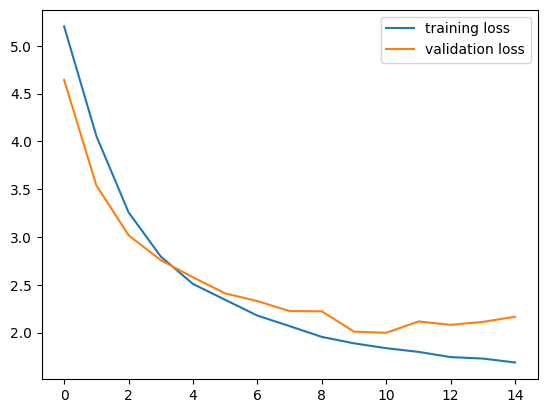

In [50]:
# Graph val_loss vs loss
plt.plot(range(epochs), hisory.history['loss'], label='training loss')
plt.plot(range(epochs), hisory.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

The result is okay. Nothing to drive home about.

Next, we will unfreeze some layers and train those later layers of this architecture.

In [52]:
# Determine our base model
base_model = ft_resnet50_model.layers[4]
base_model.trainable = True

len(base_model.layers)

175

In [54]:
fine_tune_at = 160

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False

# Decrease learning rate since trained for many epochs
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * 0.001)
metrics=['accuracy']

ft_resnet50_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

ft_resnet50_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 244, 244, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 244, 244, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

In [55]:
history = ft_resnet50_model.fit(train_ds, validation_data=val_ds, 
                                initial_epoch=history.epoch[-1], epochs=history.epoch[-1] + 20)

Epoch 70/89
200/200 [==============================] - 32s 124ms/step - loss: 1.5644 - accuracy: 0.7167 - val_loss: 1.8519 - val_accuracy: 0.7098
Epoch 71/89
200/200 [==============================] - 21s 104ms/step - loss: 1.3664 - accuracy: 0.7638 - val_loss: 1.9541 - val_accuracy: 0.6710
Epoch 72/89
200/200 [==============================] - 21s 104ms/step - loss: 1.2815 - accuracy: 0.7827 - val_loss: 1.9338 - val_accuracy: 0.7135
Epoch 73/89
200/200 [==============================] - 21s 105ms/step - loss: 1.1939 - accuracy: 0.7960 - val_loss: 1.8865 - val_accuracy: 0.7505
Epoch 74/89
200/200 [==============================] - 21s 105ms/step - loss: 1.1300 - accuracy: 0.8092 - val_loss: 1.9222 - val_accuracy: 0.7209
Epoch 75/89
200/200 [==============================] - 21s 105ms/step - loss: 1.0555 - accuracy: 0.8302 - val_loss: 1.9939 - val_accuracy: 0.7412
Epoch 76/89
200/200 [==============================] - 21s 105ms/step - loss: 1.0044 - accuracy: 0.8402 - val_loss: 1.9518 -

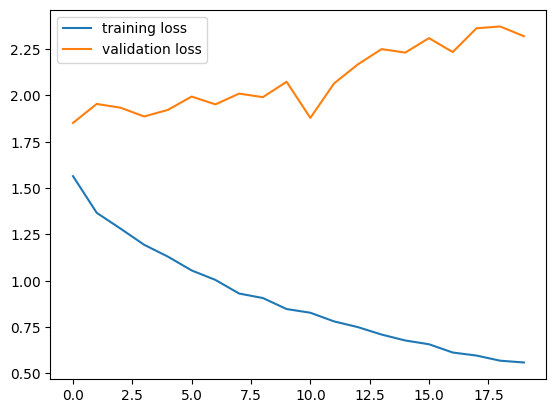

In [57]:
plt.plot(range(20), history.history['loss'], label='training loss')
plt.plot(range(20), history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

- It's the epitome of overfitting.

As expected, this doesn't give us the result we want.

After all, all models overfit with or without regularization. Adding more data seems to be the only way. However, unlike other methods, this is hard to do (right).

## Prediction on unseen data

1/1 [==============================] - 0s 19ms/step


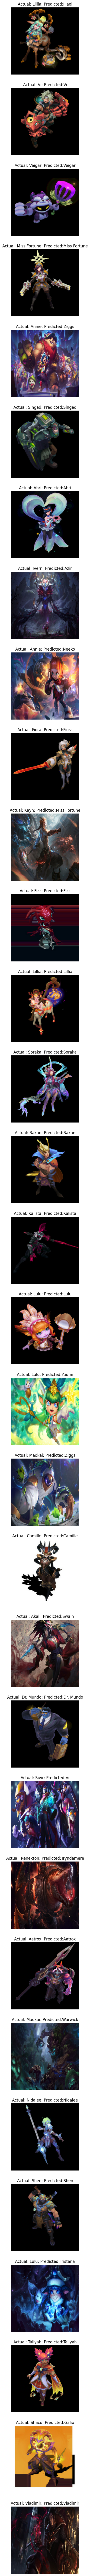

In [233]:
plt.figure(figsize=(144,144))
for images, labels in test_ds.take(1):
    predictions = ft_resnet50_model.predict(images)
    scores = tf.nn.softmax(predictions)
    for i in range(len(images)):
        ax = plt.subplot(32, 1, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Actual: {class_names[labels[i]]}: Predicted:{class_names[np.argmax(scores[i])]}")
        #predictions = model.predict(tf.expand_dims(images[i], 0))
        #score = tf.nn.softmax(predictions[0])
        plt.axis('off')

In [228]:
correct, incorrect = 0, 0
failed_classifications = {}

for images, labels in test_ds.take(33):
    predictions = ft_resnet50_model.predict(images)
    scores = tf.nn.softmax(predictions)

    for i in range(len(predictions)):
        if class_names[labels[i]] not in failed_classifications:
            failed_classifications[class_names[labels[i]]] = 0
    
        if class_names[np.argmax(scores[i])] == class_names[labels[i]]:
            correct += 1
        else:
            incorrect += 1
            failed_classifications[ class_names[labels[i]] ] += 1

1/1 [==============================] - 0s 21ms/step


In [229]:
print("Overall the model predicts with accuracy of {:.2f}%".format((correct)/(incorrect + correct) * 100)) 

Overall the model predicts with accuracy of 73.30%


1/1 [==============================] - 0s 14ms/step
This image most likely belongs to Brand with a 72.99 percent confidence. 
 Top candidates including ['Brand', 'Vayne', 'Lissandra', "Cho'Gath", 'Mordekaiser', 'Lee Sin', 'Urgot', 'Cassiopeia', 'Vladimir', 'Shaco']


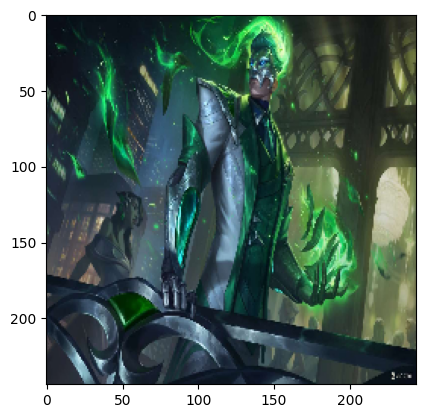

In [230]:
def get_top_10_chances(score, class_names):
    indexes = score.numpy().argsort()[-10:][::-1]

    return [class_names[index] for index in indexes]

# image from the internet
url = "https://assets-global.website-files.com/5c1bb997cb1dd611a0e6c8ce/61bc071716ef8ff7e007da42_WestStudio_LOL_Splash_0174.jpg"
image_path = tf.keras.utils.get_file(origin=url)

# Transform into array to predict
img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array.astype('uint8'))

# Create a batch
img_array = tf.expand_dims(img_array, 0)

# Make a prediction
predictions = ft_resnet50_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence. \n Top candidates including {}"
    .format(class_names[np.argmax(score)], 100 * np.max(score), get_top_10_chances(score, class_names))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to Karma with a 39.18 percent confidence. 
 Top candidates including ['Karma', "Vel'Koz", 'Shaco', 'Sona', 'Sivir', 'Zoe', 'Yuumi', 'Zed', 'Skarner', 'Gwen']


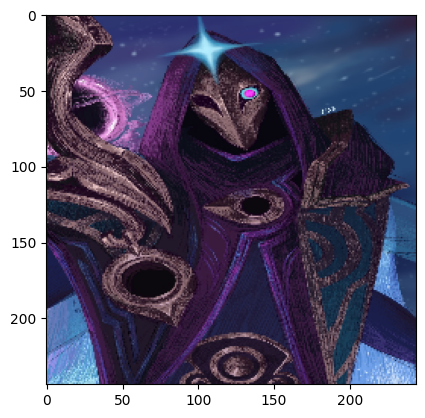

In [232]:
# another image from the internet
url = "https://i.redd.it/ww99jkah2ne41.jpg"
image_path = tf.keras.utils.get_file(origin=url)

# Transform into array to predict
img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array.astype('uint8'))

# Create a batch
img_array = tf.expand_dims(img_array, 0)

# Make a prediction
predictions = ft_resnet50_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence. \n Top candidates including {}"
    .format(class_names[np.argmax(score)], 100 * np.max(score), get_top_10_chances(score, class_names))
)

Maybe it thought this was Dark Star Karma? :D

In [195]:
# Top 10 champions wrongly classified
top_10 = Counter(failed_classifications).most_common(10)
top_10

[('Sivir', 7),
 ('Gnar', 7),
 ('Ezreal', 7),
 ('Darius', 6),
 ('Zed', 6),
 ('Kayle', 5),
 ('Warwick', 5),
 ('Lux', 5),
 ('Lee Sin', 5),
 ('Udyr', 5)]

# Save model

In [244]:
# Create model
ft_resnet50_model.save('mymodel')

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


# Conclusion

Overall the model doesn't perform too well, but as a learning experience, this serves its purpose.

It can kinda guess which champion it is from the original splash art and models. For images on the internet, however, it usually doesn't perform too well on.